# This file is only for developement
## Here the face detection and recognition algorithm was tested and studied

In [12]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torch
from copy import deepcopy
from types import MethodType
from os import listdir

(-0.5, 299.5, 199.5, -0.5)

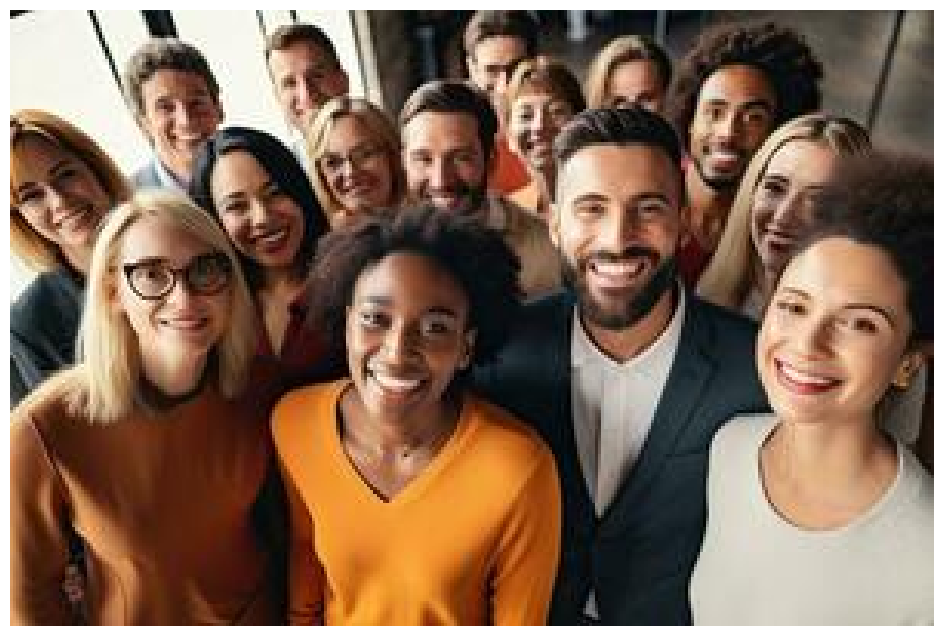

In [13]:
im_name = r"data\sample_images\28287431-grupo-do-multietnico-o-negocio-pessoas-dentro-a-escritorio-ai-gerado-foto.jpg"

frame = cv2.imread(im_name)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame_cv = deepcopy(frame)

plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

# Create face detector
mtcnn = MTCNN(select_largest=False, device=device, keep_all=True)
resnet = InceptionResnetV1(pretrained='vggface2').eval()

# Load a single image and display
frame = Image.fromarray(frame_cv)

# Detect face
faces = mtcnn(frame)
faces.shape

cpu


torch.Size([15, 3, 160, 160])

(-0.5, 299.5, 199.5, -0.5)

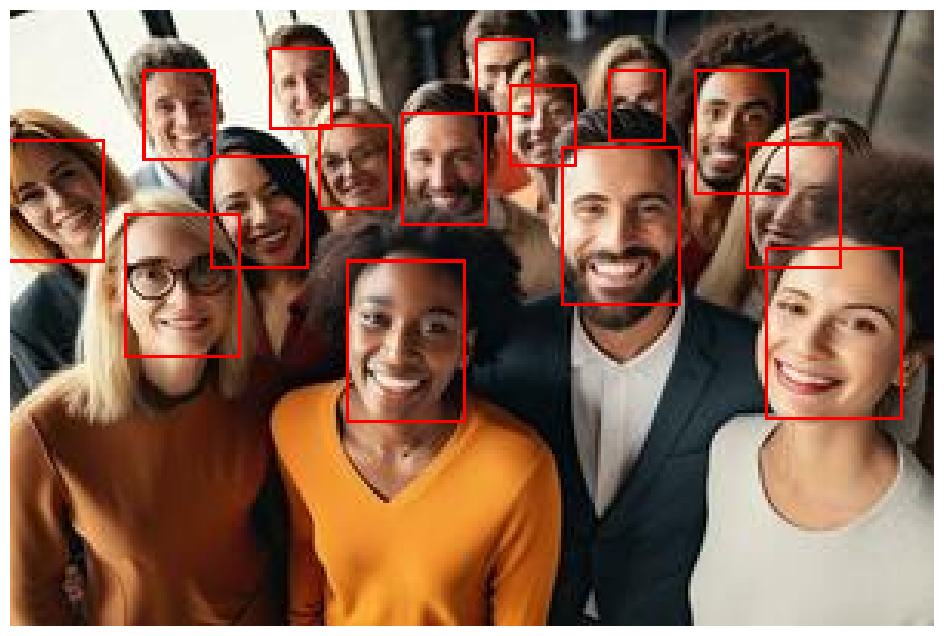

In [15]:
detections = mtcnn.detect(frame)
conf = 0.8

for i in range(len(detections[1])):
    rect = [int(val) for val in detections[0][i]]
    if detections[1][i] >= conf:
        frame_cv = cv2.rectangle(frame_cv, rect[:2], rect[2:], color=(255,0,0))

plt.figure(figsize=(12, 8))
plt.imshow(frame_cv)
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

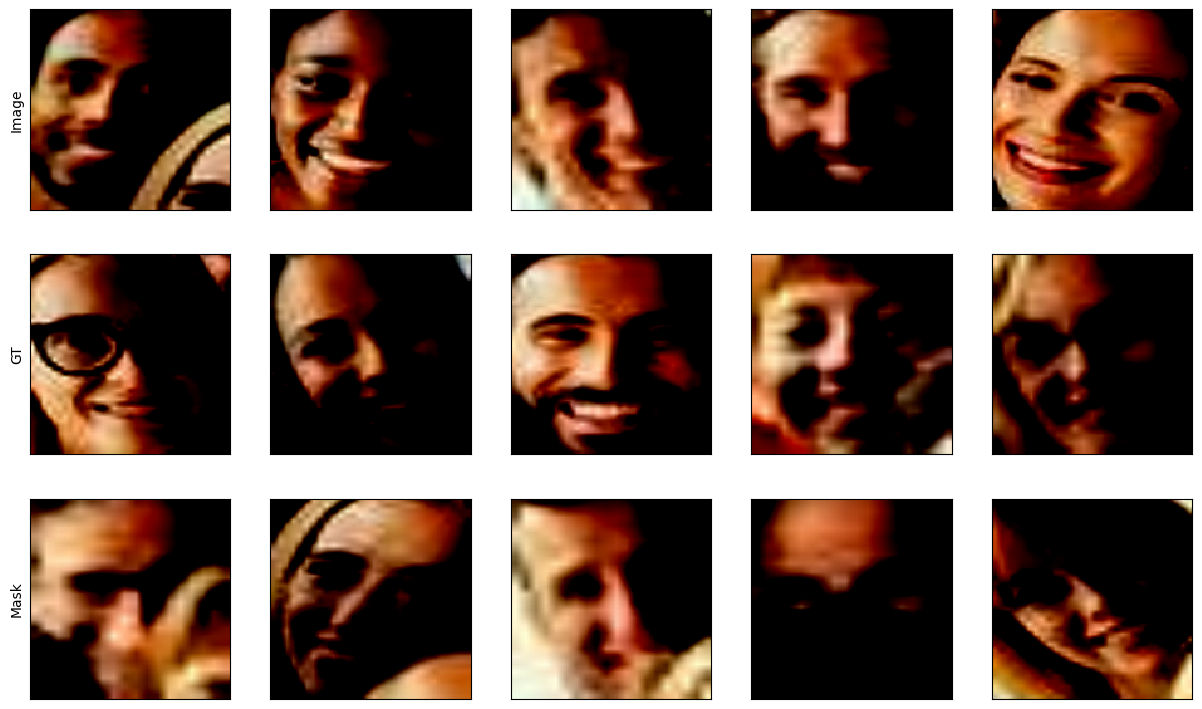

In [16]:

# Visualize
fig, ax = plt.subplots(3, 5, figsize=(15, 9))

ax[0][0].set_ylabel("Image")
ax[1][0].set_ylabel("GT")
ax[2][0].set_ylabel("Mask")

for j in range(5):
    ax[0][j].imshow(faces[j].permute(1, 2, 0).numpy(), cmap="gray", interpolation="None")
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    ax[1][j].imshow(faces[j+5].permute(1, 2, 0).numpy(), cmap="gray", interpolation="None")
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])

    ax[2][j].imshow(faces[j+10].permute(1, 2, 0).numpy(), cmap="gray", interpolation="None")
    ax[2][j].set_xticks([])
    ax[2][j].set_yticks([])

In [17]:
def encode(img):
    res = resnet(torch.Tensor(img))
    return res

def detect_box(self, img, save_path=None):
    # Detect faces
    batch_boxes, batch_probs, batch_points = self.detect(img, landmarks=True)
    # Select faces
    if not self.keep_all:
        batch_boxes, batch_probs, batch_points = self.select_boxes(
            batch_boxes, batch_probs, batch_points, img, method=self.selection_method
        )
    # Extract faces
    faces = self.extract(img, batch_boxes, save_path)
    return batch_boxes, faces

mtcnn.detect_box = MethodType(detect_box, mtcnn)

In [18]:
faces_images = "data/known_faces/"
known_faces = {}
for file in listdir(faces_images):
    person_face, extension = file.split(".")
    img = cv2.imread(f'{faces_images}/{person_face}.jpg')
    cropped = mtcnn(img)
    if cropped is not None:
        known_faces[person_face] = encode(cropped)[0, :]

In [19]:
def detect(img, thres=0.7):
    boxes, cropped_images = mtcnn.detect_box(img)

    if cropped_images is not None:
        for box, cropped in zip(boxes, cropped_images):
            x, y, x2, y2 = [int(x) for x in box]
            img_embedding = encode(cropped.unsqueeze(0))
            detect_dict = {}
            for k, v in known_faces.items():
                detect_dict[k] = (v - img_embedding).norm().item()
            min_key = min(detect_dict, key=detect_dict.get)

            if detect_dict[min_key] >= thres:
                min_key = 'Undetected'
            
            cv2.rectangle(img, (x, y), (x2, y2), (0, 0, 255), 2)
            cv2.putText(
                img, min_key, (x + 5, y + 10),
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 0, 0), 1)
                
        return img

(-0.5, 611.5, 424.5, -0.5)

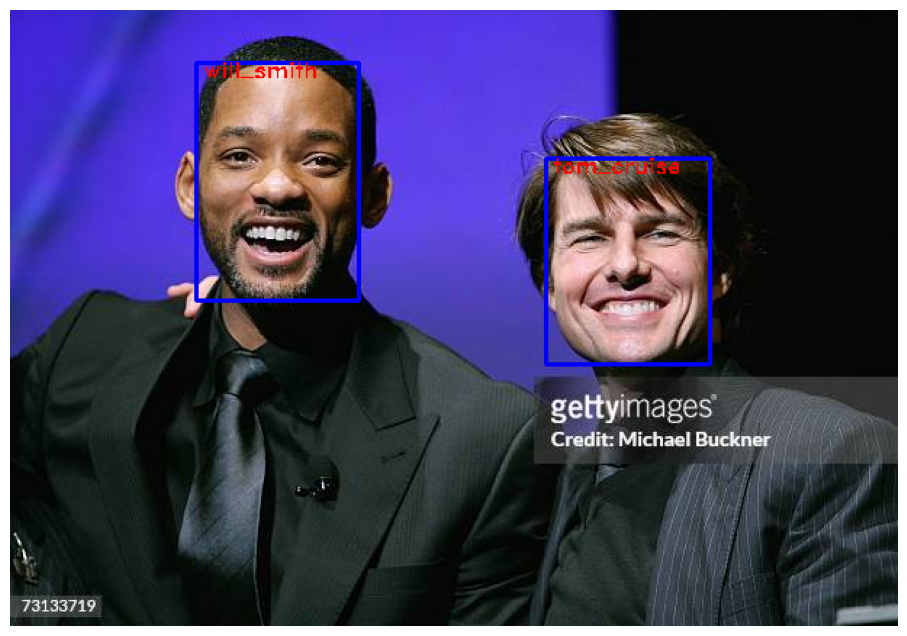

In [20]:
img_path = r"data\sample_images\gettyimages-73133719-612x612.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
detected = detect(image, 0.8)

plt.figure(figsize=(12, 8))
plt.imshow(detected)
plt.axis('off')